In [1]:
# SETUP

import warnings
warnings.simplefilter('ignore')

import os
os.environ['CONFIG_FILE'] = 'conf/default.cfg'

import pandas as pd
import numpy as np

from collections import Counter

from metacorps.projects.common.export_project import ProjectExporter

df = ProjectExporter('EPA Metvi').export_dataframe()

# Results

Here are the guiding hypotheses for this study of instances of violence metaphors on cable news where the subject of the violence is the EPA, or other regulations/regulators, and the violence was some kind of strangling. We want to know who says these metaphors, on what channel it was said, who were the subject and object of violence, and when were these metaphors said.

* We expect that around the time of the 2016 election there will be increased use of the metaphors of interest due to generally increased excitement and due to the role the media play as cheerleaders, agenda setters, and expectation setters. 
* We expect that Fox-owned channels Fox News and Fox Business Channel will feature more of the metaphors of interest because the idea that regulatory harm is a great concern is a component of their ideological bias and because their audience is largely composed of people in the (sub-) “Culture of Honor.” People in this United States subculture are the descendents of Scots-Irish, who are claimed to be more intrinsically aggressive than many other ethnic groups in the United States; there is some empirical evidence to support this. 
* For similar reasons for the preceding hypothesis, we expect Republican politicians to more commonly use the metaphors of interest. 
* We expect that there will be a set of common and a few rare objects of metaphorical violence. Common objects will include variants of “business” and “business men and women,” and “the economy,” and perhaps others.

## Time course of violence metaphor use

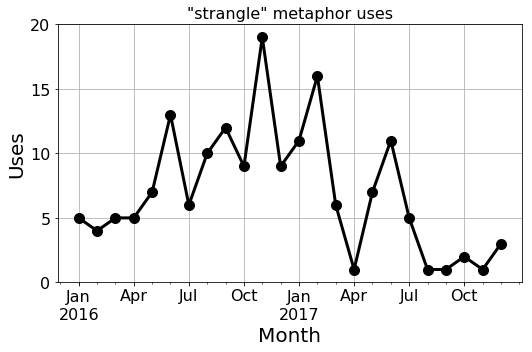

In [134]:
c = Counter(df.start_localtime.dt.date)

s = pd.Series(index=c.keys(), data=list(c.values()))

s2 = pd.Series(index=pd.date_range('2016-01-01', '2017-12-31', freq='D'),
               data=0.0)

s2[s.index] = s.data

s2 = s2.resample('1M').sum()
plt.figure(figsize=(7.5, 5))
s2.plot(style='ko-', ms=10, lw=3)
plt.ylim(0, 20)

plt.ylabel('Uses', size=14)
plt.xlabel('Month', size=14)
plt.yticks(np.arange(0, 21, 5))
plt.xticks(['2016-01-15', '2016-04-15', '2016-07-15', 
            '2016-10-15', '2017-01-15', '2017-04-15',
            '2017-07-15', '2017-10-15'])
# plt.gca().grid(axis='x', which='major')
# plt.gca().grid(axis='y', which='major')
plt.tick_params(axis='y', which='both', labelsize=16)
plt.tick_params(axis='x', which='both', labelsize=16)
plt.xlabel('Month', size=20)
plt.ylabel('Uses', size=20)
plt.grid(axis='both')
plt.title('"strangle" metaphor uses', size=16)
plt.savefig('/Users/mt/Desktop/AGU Presentation/Figures/timeseries.png', dpi=300)

## Channel featuring violence metaphors

In [3]:
## 
# Thinking of going with monthly data as basis. 
# Results in sufficiently large numbers, but fine
# scale enough to see shifts potentially partially
# explained through cultural considerations.
#

# How to get counts per channel per month, then?
# First make reduced series as in above, but just using date
# and channel.

def rename_networks(networks):

    network_renamed = networks.copy()
    nr = network_renamed

    # See https://en.wikipedia.org/wiki/Fox_Entertainment_Group#Fox_News_Group
    nr[nr == 'FBC'] = 'Fox Entertainment Group'
    nr[nr == 'FOXNEWSW'] = 'Fox Entertainment Group'

    nr[nr.apply(lambda s: 'CSPAN' in s)] = 'CSPAN'

    nr[nr == 'CNNW'] = 'CNN'

    nr[nr == 'BLOOMBERG'] = 'Bloomberg'
    nr[nr == 'MSNBCW'] = 'NBCUniversal'
    nr[nr == 'CNBC'] = 'NBCUniversal'
    
    return network_renamed


network_renamed = rename_networks(df.network)
c = Counter(network_renamed)

c.most_common()

c

lim = {k: v for k, v in c.items() if v > 1}

lim

{'CSPAN': 57,
 'Fox Entertainment Group': 72,
 'Bloomberg': 7,
 'NBCUniversal': 18,
 'CNN': 10}

2016-01-31     1.0
2016-04-30     3.0
2016-07-31    10.0
2016-10-31    19.0
2017-01-31    12.0
2017-04-30    13.0
2017-07-31    10.0
2017-10-31     1.0
2018-01-31     3.0
dtype: float64
72.0
57.0


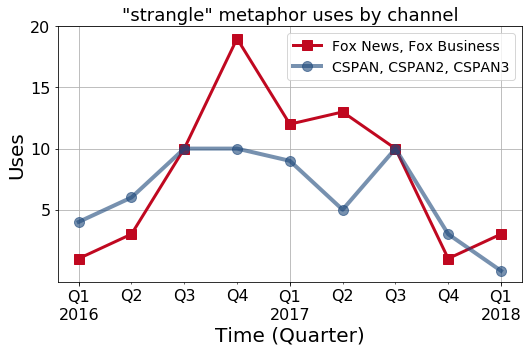

In [139]:
dfc = df.copy()

dfc.network = network_renamed

all_dates = pd.date_range('2016-01-01', '2017-12-31', freq='D')
fox_ts = pd.Series(index=all_dates, data=0.0)
cspan_ts = pd.Series(index=all_dates, data=0.0)

fox_dates = dfc[dfc.network == 'Fox Entertainment Group'].start_localtime.dt.date
fox_counts = Counter(fox_dates)

for date, count in fox_counts.items():
    fox_ts[date] = count
    
cspan_dates = dfc[dfc.network == 'CSPAN'].start_localtime.dt.date
cspan_counts = Counter(cspan_dates)

for date, count in cspan_counts.items():
    cspan_ts[date] = count

print(fox_ts.resample('3M').sum())
print(fox_ts.resample('3M').sum().sum())
print(cspan_ts.resample('3M').sum().sum())
plt.figure(figsize=(7.5, 5))
fox_ts.resample('3M').sum().plot(color='#C00820', marker='s', lw=3, ms=10, label='Fox News, Fox Business')
cspan_ts.resample('3M').sum().plot(color='#1D487B', marker='o', lw=4, ms=10, label='CSPAN, CSPAN2, CSPAN3', alpha=0.6)
plt.yticks(range(5, 21, 5))
plt.tick_params(axis='y', which='both', labelsize=16)
plt.tick_params(axis='x', which='both', labelsize=16)
plt.xlabel('Time (Quarter)', size=20)
plt.ylabel('Uses', size=20)
plt.grid(axis='both')
plt.legend(fontsize=14)
plt.title('"strangle" metaphor uses by channel', size=18)
plt.savefig('/Users/mt/Desktop/AGU Presentation/Figures/fox_cspan_timecourse.png', dpi=300)

For some reason, there is data in Q1 2018 if we don't include the slice above. Need to figure out what that's about.

So much for exploring uses per channel. On to uses per speaker.

## Uses per speaker

In [126]:
all_speakers = []
speakers = []
df_cp = df.copy()

for speaker in df_cp.spoken_by:
    all_speakers.extend([s.strip() for s in speaker.split(',')])
print(len(all_speakers))


df_cp.spoken_by[df_cp.spoken_by == 'Gary Cohn; quoted by Stephanie Rhule'] = 'Gary Cohn'
# df_cp.spoken_by[df_cp.spoken_by == ' Tom Marino (R-Pennsylvania; 10th District)'] = 'Tom Marino (R-Pennsylvania; 10th District)'
for speaker in df_cp.spoken_by:
    if speaker and (speaker != 'host') and (speaker != 'Panelist') and (speaker != 'contributor'):
        speakers.extend([s.strip() for s in speaker.split(',')])

# I was worried about this below, but it's OK.
# Prints out {'Neil Cavuto'} because that's the only 
# time there are two people in Spoken By

# print(len(all_speakers))
# print(len(df_cp.spoken_by))
# print(set(all_speakers) - set(df_cp.spoken_by))

speaker_counts = Counter(speakers)

speaker_counts.most_common()

republicans = [speaker for speaker in speakers 
               if '(R-' in speaker]

repub_counts = Counter(republicans)
print(repub_counts.most_common(10))

172
[('John Cornyn (R-Texas; Senate)', 5), ('Dan Sullivan (R-Alaska; Senate)', 3), ('Bob Goodlatte (R-Virginia)', 2), ('Tom Marino (R-Pennsylvania; 10th District)', 2), ('Liz Cheney (R-Wyoming; At Large)', 2), ('Paul Ryan (R-Wisconsin; 1st District)', 2), ('Bill Huizenga (R-Michigan; 2nd District)', 2), ('Jeb Hensarling (R-Texas; Financial Services Committee Chair)', 2), ('Lamar Alexander (R-Tennessee; Senate)', 2), ('Asa Hutchinson (R-Arkansas; Governor)', 2)]


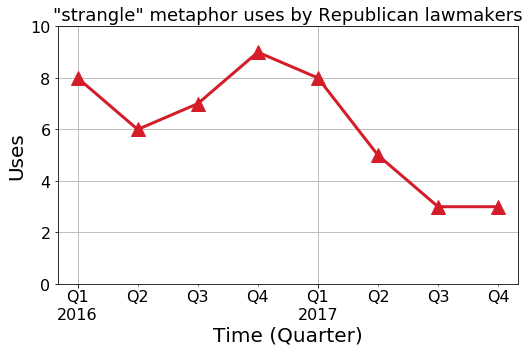

In [122]:
repub_ts = pd.Series(index=all_dates, data=0.0)

df_repub = df_cp[
    df_cp.spoken_by.apply(lambda s: '(R-' in s)
]


repub_dates = df_repub.start_localtime.dt.date
repub_counter = Counter(repub_dates)
for date, count in repub_counter.items():
    repub_ts[date] = count
    
repub_resample = repub_ts.resample('3M', closed='left', label='right', convention='start').sum()[:-1]

plt.figure(figsize=(7.5, 5))
ax = repub_resample.plot(marker='^', color='#D41D28', lw=3, ms=14)
plt.grid(axis='both')
plt.tick_params(axis='y', which='both', labelsize=16)
plt.tick_params(axis='x', which='both', labelsize=16)

ax.set_xlim(['2016-2-1', '2018-1-1'])

ax.set_xticks(['2016-3-31', '2016-6-30', '2016-9-30', '2016-12-31',
               '2017-3-31', '2017-6-30', '2017-9-30', '2017-12-31'], minor=True)
ax.set_xticks(['2016-3-31', '2017-3-31'], minor=False)

xlabels = ['Q1\n2016', 'Q2', 'Q3', 'Q4', 'Q1\n2017', 'Q2', 'Q3', 'Q4']
ax.set_xticklabels(xlabels, minor=True)
plt.xlabel('Time (Quarter)', size=20)
plt.ylabel('Uses', size=20)
plt.ylim(0, 10)
plt.title('"strangle" metaphor uses by Republican lawmakers', size=18)

plt.savefig('/Users/mt/Desktop/AGU Presentation/Figures/republicans.png', dpi=300)

In [135]:
print(speaker_counts.most_common(5))
sum(np.array(list(speaker_counts.values())) == 2)

[('Maria Bartiromo', 16), ('Donald Trump', 9), ('John Cornyn (R-Texas; Senate)', 5), ('Paul Ryan', 4), ('Kellyanne Conway', 4)]


15

So much for who says the metaphors on what network. On to looking at the objects of metaphorical violence.

## Common objects of metaphorical violence

In [149]:
objs_counter = Counter([splitted for el in df.objects 
                        for splitted in el.split(',') 
                        ])
print(objs_counter.most_common(20))

objs_clean = df.objects.copy()

oc = objs_clean
oc[oc.apply(lambda s: 'business' in s)] = 'business'
oc[oc.apply(lambda s: 'economy' in s)] = 'economy'
oc = oc[oc != '']
Counter(oc).most_common(10)

[('businesses', 17), ('small businesses', 14), ('business', 11), ('the economy', 11), ('', 11), ('our economy', 10), ('economy', 8), ('small business', 5), ('companies', 4), ('jobs', 4), (' businesses', 4), (' our economy', 4), (' small businesses', 3), ('american businesses', 3), ('banks', 3), (' jobs', 2), ('coal industry', 2), ('us', 2), ('this country', 2), ('community financial institutions', 2)]


[('business', 67),
 ('economy', 38),
 ('companies', 3),
 ('this country', 2),
 ('community financial institutions', 2),
 ('economic growth', 2),
 ('banks', 2),
 ('domestic energy portfolio', 1),
 ('economic recovery, economic opportunities', 1),
 ('innovative investors', 1)]